In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
rm Displacement*

rm: cannot remove 'Displacement*': No such file or directory


In [3]:
from fenics import *
from mshr import *
from pdb import set_trace as bp

In [4]:
Lx,Ly = 2e-3, 1e-3
nx = 40
ny = np.ceil(nx*Ly)
FORCED = 1
longitudinal = 1
shear = int(not longitudinal)

base = Rectangle(Point(0, 0), Point(Lx, Ly))

d0 = 1e-3
p0 = 1.7e3

E = 0.2e9
rho = 1e3
nu = 0.35

lmda = (E*nu) / (1+nu)/(1 - (2*nu))
mu = E/(2*(1+nu))

T = Lx/sqrt(E/rho)#1e-3
nT = 100
dt = T/nT

tip1 = (Lx,Ly)
dispTip1 = np.zeros((nT,2))

tForce = dt#0.3*T

t = np.linspace(0, T, nT,endpoint=True)

Energies = np.zeros((nT,4))

beta,gamma = 0.25,0.5

omega,dOmega = 1,2

numCircles = 500
poreMu,poreSigma = 0.1,0.0001
location = [0,0]
poreDiameter = []
numCir = int(0)
currentInclusionVolume = 0
offset = 0.5*poreMu#+poreSigma

inclusionVolume = 0.0


In [5]:
if inclusionVolume>0:
    while numCir<numCircles:

        xlocation = Lx * np.random.rand()
        ylocation = Lx * np.random.rand()

        if xlocation < offset or xlocation > Lx - offset:
            continue

        if ylocation < offset or ylocation > Ly - offset:
            continue
        dia = np.random.normal(poreMu, poreSigma, 1)

        if numCir>1:
            distance = np.sqrt((xlocation-location[:,0])**2 + (ylocation-location[:,1])**2)
            check = 0.5*dia > (1-((0.5*poreDiameter)
                                  /distance))*distance
            cond = any(check)
            if cond==True:
                continue

        currentInclusionVolume = (currentInclusionVolume + 0.25*3.14*dia**2)
        if currentInclusionVolume >= inclusionVolume:
            break
        currentlocation = [xlocation,ylocation]
        poreDiameter = np.concatenate((poreDiameter, dia),axis=0)
        location = np.vstack((location,currentlocation))

        if numCir==0:
            location=location[1:,:]

        numCir += 1
    print("Number of inclusions = ",numCir)
    print("Porosity acheived = ",currentInclusionVolume.tolist())

    for i in range(numCir):
        hole = Circle(Point(location[i,0],location[i,1]), 0.5*poreDiameter[i])
        base = base - hole

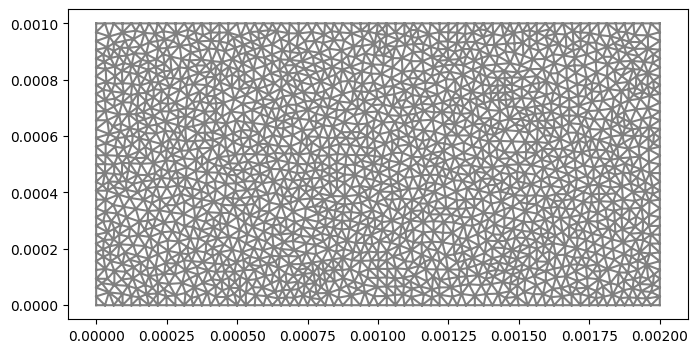

In [6]:
mesh = generate_mesh(base,nx)
# mesh = RectangleMesh(Point(0.,0.),Point(Lx,Ly),int(nx),int(ny))
figure(num=None, figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k')
plot(mesh)
boundaries = MeshFunction("size_t",mesh, mesh.topology().dim()-1)

In [7]:
solSpace = VectorFunctionSpace(mesh,"CG",1)

testFunc = TestFunction(solSpace)
trialFunc = TrialFunction(solSpace)

if FORCED==0:
    dB = interpolate(Expression(("d0*x[0]","0"),d0=d0,degree=4),solSpace,name="Displacement")
else:
    dB = Function(solSpace,name="Displacement")
    
vB = Function(solSpace,name="Velocity")
aB = Function(solSpace,name="Acceleration")

def p(step):
#     P_ = Expression(("tc <= tF ? p0 : 0","0.0"),tc=t[step], tF=tForce, p0=p0,degree=2)
#     P_ = Expression(("tc <= tF ? p0*tc/tF : 0","0."), tc=t[step], tF=tForce, p0=p0, degree=0)
    P_ = Expression(("tc <= tF ? Longitudinal*p0*sin(omega*pi*tc/tF)*sin(dOmega*pi*tc/tF) : 0",\
                     "tc <= tF ? Shear*p0*sin(omega*pi*tc/tF)*sin(dOmega*pi*tc/tF) : 0"),\
                    tc=t[step],tF=tForce,p0=p0,omega=omega,dOmega=dOmega,degree=2,\
                    Longitudinal=longitudinal,Shear=shear)
    return P_

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


In [8]:
def sigma(r):
    return 2.0*mu*sym(grad(r)) + lmda*tr(sym(grad(r)))*Identity(len(r))

def epslon(r):
    return sym(grad(r))*Identity(len(r))

def m(trialFunc, testFunc):
    return rho*inner(trialFunc, testFunc)*dx

def k(trialFunc, testFunc):
    return inner(sigma(trialFunc), sym(grad(testFunc)))*dx

def fExt(testFunc,step):
    forceApplied = inner(p(step),testFunc)*ds(2)
    force = assemble(forceApplied)
    forceVec=force.get_local()
#     print([step,forceVec])
    return forceVec

In [9]:
class left_bnd(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0],0.0)

class right_bnd(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near (x[0],Lx)

left = left_bnd()
right = right_bnd()

boundaries.set_all(0)
left.mark(boundaries,1)
right.mark(boundaries,2)

ds = Measure("ds")[boundaries]

bcl = DirichletBC(solSpace,Constant((0.0,0.0)),left)

Notation dx[meshfunction] is deprecated. Please use dx(subdomain_data=meshfunction) instead.


In [10]:
outfileD = File('Displacement.pvd')

disp = project(dB,solSpace)
disp.rename("Displacement"," ")
# outfileD << disp

dispTip1[0,0],dispTip1[0,1] = disp(tip1)[0],disp(tip1)[1]

K = PETScMatrix()
M = PETScMatrix()

assemble(k(trialFunc,testFunc), tensor=K)
assemble(m(trialFunc,testFunc), tensor=M)
bcl.apply(K)
bcl.apply(M)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


In [11]:
ep = 0.5*np.dot(dB.vector(),np.dot(K.array(),dB.vector()))
ek = 0.5*np.dot(vB.vector(),np.dot(M.array(),vB.vector()))
eExt = np.dot(fExt(testFunc,0),vB.vector())
Energies[0,:] = [ep,ek,eExt,ep+ek]

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


In [12]:
aI = np.linalg.solve(M.array(),\
           fExt(testFunc,0) -np.dot(K.array(),dB.vector()))

aB.vector()[:] = aI

In [13]:
AM = M + (beta*dt*dt)*K
for i in np.arange(1,nT):     
    fT = fExt(testFunc,i)-np.dot(K.array(),(dB.vector() + dt*vB.vector() \
                            + 0.5*dt*dt*(1- 2*beta)*aB.vector()))

    a_ = np.linalg.solve(AM.array(),fT)
    v_ = vB.vector()[:] + dt*((1-gamma)*aB.vector()[:] + gamma*a_)
    d_ = dB.vector()[:] + dt*vB.vector()[:] +\
         0.5*dt**2*((1-2*beta)*aB.vector()[:] + 2*beta*a_)

    aB.vector()[:] = a_
    dB.vector()[:] = d_
    vB.vector()[:] = v_
    
    disp = project(dB,solSpace)
    
    dispTip1[i,0],dispTip1[i,1] = disp(tip1)[0],disp(tip1)[1]
    
    disp.rename("Displacement"," ")
#     outfileD << disp
    
    ep = 0.5*np.dot(dB.vector(),np.dot(K.array(),dB.vector()))
    ek = 0.5*np.dot(vB.vector(),np.dot(M.array(),vB.vector()))
    eExt = np.dot(fExt(testFunc,i),vB.vector())
    
    Energies[i,:] = [ep,ek,eExt,ep+ek]


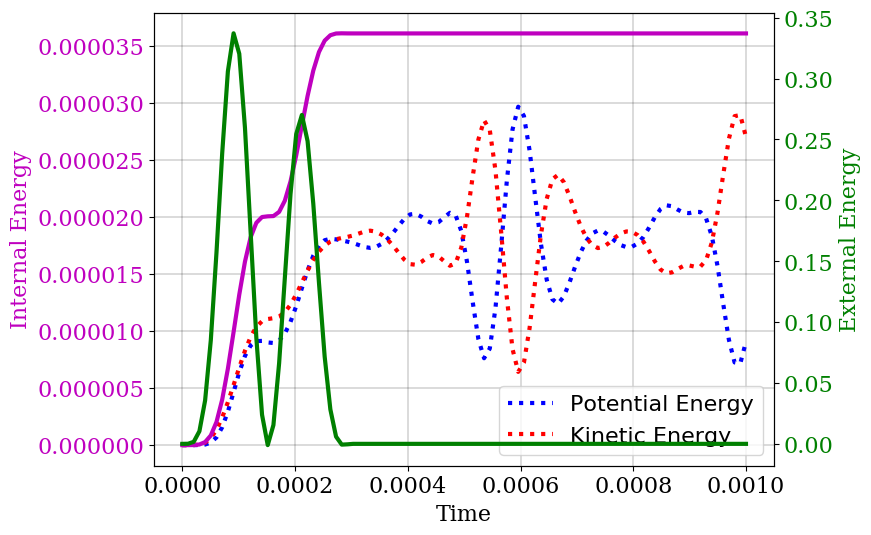

In [14]:
fig, ax1 = plt.subplots(num=None, figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k')
grid(color='k',linewidth=0.2)
ax1.set_xlabel("Time",size=16,fontfamily='serif')
ax1.set_ylabel("Internal Energy",color='m',size=16,fontfamily='serif')
ax1.plot(t,Energies[:,0],':b',t,Energies[:,1],':r',t,Energies[:,3],'m',linewidth=3)
plt.xticks(color='k', size=16,fontfamily='serif')
plt.yticks(color='m', size=16,fontfamily='serif')
plt.legend(("Potential Energy","Kinetic Energy"),fontsize=16)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('External Energy',color='g',size=16,fontfamily='serif')  # we already handled the x-label with ax1
ax2.plot(t, Energies[:,2],'g',linewidth=3)
plt.yticks(color='g', size=16,fontfamily='serif')
plt.savefig('energiesArrays.eps',bbox_inches='tight')

In [15]:
# figure(num=None, figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k')
# plt.plot(t,Energies[:,0],'b',t,Energies[:,1],'r',t,Energies[:,3],'k',linewidth=3)
# plt.xlabel("Time",size=16,fontfamily='serif')
# plt.ylabel("Energy",size=16,fontfamily='serif')
# plt.xticks(color='k', size=16,fontfamily='serif')
# plt.yticks(color='k', size=16,fontfamily='serif')
# plt.legend(("Potential Energy","Kinetic Energy","Total Energy"),fontsize=16)
# plt.savefig('energies2.eps',bbox_inches='tight')

In [16]:
# Energies

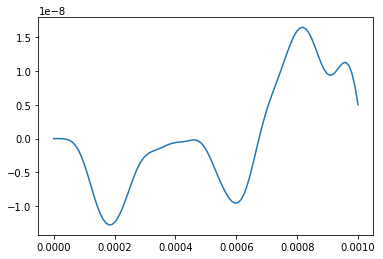

In [19]:
plt.plot(t,dispTip1[:,0])